In [1]:
import numpy as np
from utils import * 
import skimage as sk
import os
from pylab import *
import torch
from torchmetrics.image import UniversalImageQualityIndex
from ops import *

In [2]:
os.getcwd()

'/Users/mingxiaowei/Desktop/Colorizing-with-GANs/src'

In [3]:
def demo_img_read(img):
    return sk.img_as_float(sk.io.imread(os.path.join(os.getcwd(), os.path.join('../demo_img/', img))))

In [4]:
i170 = demo_img_read('i17_0.jpg')
i171 = demo_img_read('i17_1.jpg')
i172 = demo_img_read('i17_2.jpg')
i173 = demo_img_read('i17_3.jpg')
im170_gray = sk.color.rgb2gray(i170)

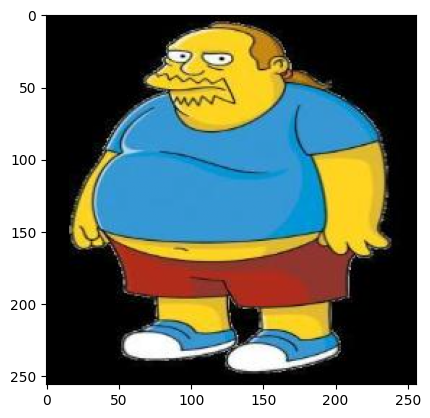

In [5]:
imshow(i170);

In [14]:
def rmse(im1, im2):
    return np.sqrt(np.mean((im1 - im2) ** 2))

def uiqi(im1, im2):
    from torchmetrics.image import UniversalImageQualityIndex
    uqi = UniversalImageQualityIndex()
    im1 = im1.transpose(2, 0, 1)
    im2 = im2.transpose(2, 0, 1)
    return uqi(torch.from_numpy(im1).unsqueeze(0), torch.from_numpy(im2).unsqueeze(0))

def acc(im1, im2, epsilon=1e-3):
    im1 = im1.transpose(2, 0, 1)
    im1 = torch.from_numpy(im1).unsqueeze(0).type(torch.float64)
    im2 = im2.transpose(2, 0, 1)
    im2 = torch.from_numpy(im2).unsqueeze(0).type(torch.float64)
    return pixelwise_accuracy(im1, im2, 'RGB', 2.0)

def pixelwise_accuracy(img_real, img_fake, colorspace, thresh):
    """
    Measures the accuracy of the colorization process by comparing pixels
    """
    img_real = postprocess(img_real, colorspace, COLORSPACE_LAB)
    img_real = tf.cast(img_real, tf.float64)
    img_fake = postprocess(img_fake, colorspace, COLORSPACE_LAB)
    img_fake = tf.cast(img_fake, tf.float64)

    diffL = tf.abs(tf.round(img_real[..., 0]) - tf.round(img_fake[..., 0]))
    diffA = tf.abs(tf.round(img_real[..., 1]) - tf.round(img_fake[..., 1]))
    diffB = tf.abs(tf.round(img_real[..., 2]) - tf.round(img_fake[..., 2]))

    # within %thresh of the original
    predL = tf.cast(tf.less_equal(diffL, 1 * thresh), tf.float64)        # L: [0, 100]
    predA = tf.cast(tf.less_equal(diffA, 2.2 * thresh), tf.float64)      # A: [-110, 110]
    predB = tf.cast(tf.less_equal(diffB, 2.2 * thresh), tf.float64)      # B: [-110, 110]

    # all three channels are within the threshold
    pred = predL * predA * predB

    return tf.reduce_mean(pred)

def rgb_to_lab(srgb):
    # based on https://github.com/torch/image/blob/9f65c30167b2048ecbe8b7befdc6b2d6d12baee9/generic/image.c
    with tf.name_scope("rgb_to_lab"):
        srgb_pixels = tf.reshape(srgb, [-1, 3])

        with tf.name_scope("srgb_to_xyz"):
            linear_mask = tf.cast(srgb_pixels <= 0.04045, dtype=tf.float64)
            exponential_mask = tf.cast(srgb_pixels > 0.04045, dtype=tf.float64)
            rgb_pixels = (srgb_pixels / 12.92 * linear_mask) + (((srgb_pixels + 0.055) / 1.055) ** 2.4) * exponential_mask
            rgb_to_xyz = tf.constant([
                #    X        Y          Z
                [0.412453, 0.212671, 0.019334],  # R
                [0.357580, 0.715160, 0.119193],  # G
                [0.180423, 0.072169, 0.950227],  # B
            ], dtype=tf.float64)
            xyz_pixels = tf.matmul(rgb_pixels, rgb_to_xyz)

        # https://en.wikipedia.org/wiki/Lab_color_space#CIELAB-CIEXYZ_conversions
        with tf.name_scope("xyz_to_cielab"):

            # normalize for D65 white point
            xyz_normalized_pixels = tf.multiply(xyz_pixels, [1 / 0.950456, 1.0, 1 / 1.088754])

            epsilon = 6 / 29
            linear_mask = tf.cast(xyz_normalized_pixels <= (epsilon**3), dtype=tf.float64)
            exponential_mask = tf.cast(xyz_normalized_pixels > (epsilon**3), dtype=tf.float64)
            fxfyfz_pixels = (xyz_normalized_pixels / (3 * epsilon**2) + 4 / 29) * linear_mask + (xyz_normalized_pixels ** (1 / 3)) * exponential_mask

            # convert to lab
            fxfyfz_to_lab = tf.constant([
                #  l       a       b
                [0.0, 500.0, 0.0],  # fx
                [116.0, -500.0, 200.0],  # fy
                [0.0, 0.0, -200.0],  # fz
            ], dtype=tf.float64)
            lab_pixels = tf.matmul(fxfyfz_pixels, fxfyfz_to_lab) + tf.constant([-16.0, 0.0, 0.0], dtype=tf.float64)

        return tf.reshape(lab_pixels, tf.shape(srgb))

def postprocess(img, colorspace_in, colorspace_out):
    if colorspace_in.upper() == COLORSPACE_RGB:
        # [-1, 1] => [0, 1]
        img = (img + 1) / 2

        if colorspace_out == COLORSPACE_LAB:
            img = rgb_to_lab(img)

    elif colorspace_in.upper() == COLORSPACE_LAB:
        L_chan, a_chan, b_chan = tf.unstack(img, axis=3)

        # L: [-1, 1] => [0, 100]
        # A, B: [-1, 1] => [-110, 110]
        img = tf.stack([(L_chan + 1) / 2 * 100, a_chan * 110, b_chan * 110], axis=3)

        if colorspace_out == COLORSPACE_RGB:
            img = lab_to_rgb(img)

    return img

In [15]:
for im in [i171, i172, i173]:
    print('RMSE = ', rmse(i170, im))
    print('UIQI = ', uiqi(i170, im))
    print('ACC = ', acc(i170, im))
    print()

RMSE =  0.25015907851406993


/opt/homebrew/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `UniversalImageQualityIndex` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


UIQI =  tensor(0.2640, dtype=torch.float64)
ACC =  tf.Tensor(0.25, shape=(), dtype=float64)

RMSE =  0.22584319971429812
UIQI =  tensor(0.2974, dtype=torch.float64)
ACC =  tf.Tensor(0.4453125, shape=(), dtype=float64)

RMSE =  0.289794657714676
UIQI =  tensor(0.1783, dtype=torch.float64)
ACC =  tf.Tensor(0.2513020833333333, shape=(), dtype=float64)



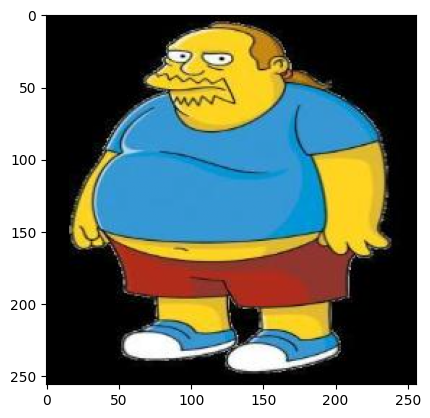

In [18]:
imshow(i170)

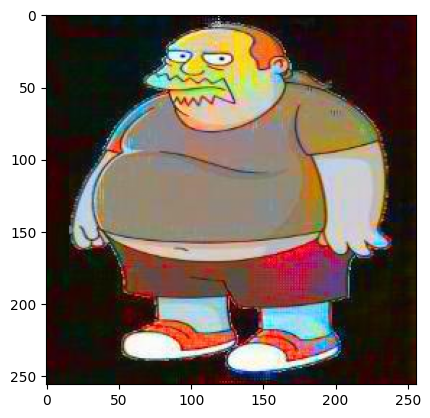

In [16]:
imshow(i172);

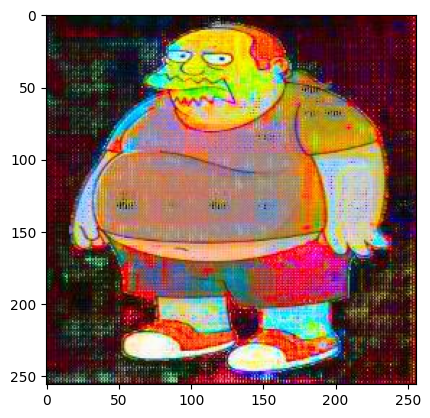

In [17]:
imshow(i173);